In [1]:
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
from loguru import logger

In [2]:
# Set up logging
logger.add("../logs/model_training.log", rotation="500 MB")

1

In [3]:
logger.info("Starting model training")

2024-08-08 17:49:18.132 | INFO     | __main__:<module>:1 - Starting model training


In [4]:
def load_data():
    """Load the diabetes dataset from Parquet files."""
    X_train = pq.read_table('../data/interim/X_train.parquet').to_pandas()
    X_val = pq.read_table('../data/interim/X_val.parquet').to_pandas()
    X_test = pq.read_table('../data/interim/X_test.parquet').to_pandas()
    y_train = pq.read_table('../data/interim/y_train.parquet').to_pandas()['target']
    y_val = pq.read_table('../data/interim/y_val.parquet').to_pandas()['target']
    y_test = pq.read_table('../data/interim/y_test.parquet').to_pandas()['target']
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [5]:
# Load data
X_train, X_val, X_test, y_train, y_val, y_test = load_data()
logger.info(f"Data loaded. Training set shape: {X_train.shape}")

2024-08-08 17:49:18.386 | INFO     | __main__:<module>:3 - Data loaded. Training set shape: (264, 10)


In [6]:
def create_pipeline(X):
    """
    Create a pipeline (compatible with the MS RAI Toolkit).

    This function creates a scikit-learn pipeline that preprocesses both numeric
    and categorical features, and includes a Random Forest Regressor as the final
    estimator. The pipeline is designed to be compatible with the Responsible AI
    (RAI) Toolkit.

    Args:
        X (pandas.DataFrame): The input features DataFrame.

    Returns:
        sklearn.pipeline.Pipeline: A scikit-learn pipeline that includes
        preprocessing steps for both numeric and categorical features,
        followed by a Random Forest Regressor.

    The pipeline includes the following steps:
    1. Preprocessing:
        a. For numeric features:
            - Imputation of missing values with median strategy
            - Standard scaling
            - Discretization using K-bins with 10 bins
        b. For categorical features:
            - Imputation of missing values with 'missing' as the fill value
            - One-hot encoding
    2. Random Forest Regressor with 1000 estimators

    Note:
        The function automatically detects numeric and categorical columns
        in the input DataFrame.
    """

    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = X.select_dtypes(include=['object', 'bool']).columns.tolist()
    
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        #('discretizer', KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile'))
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        #('regressor', RandomForestRegressor(n_estimators=1000, random_state=42))
        ('classifier', RandomForestClassifier(n_estimators=1000, random_state=42))
    ])
    
    return pipeline

In [7]:
# Create and train the model
model = create_pipeline(X_train)
model.fit(X_train, y_train)
logger.info("Model trained")

2024-08-08 17:49:24.849 | INFO     | __main__:<module>:4 - Model trained


In [8]:
def evaluate_rg_model(model, X, y, dataset_name):
    """Evaluate the model and log the results."""
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    logger.info(f"{dataset_name} - MSE: {mse:.4f}, R2: {r2:.4f}")

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


def evaluate_cf_model(model, X, y, dataset_name, display_matrix=False):
    """Evaluate the classification model, log the results, and optionally display a confusion matrix."""
    y_pred = model.predict(X)

    # Calculate the evaluation metrics
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='weighted')
    recall = recall_score(y, y_pred, average='weighted')
    f1 = f1_score(y, y_pred, average='weighted')
    cm = confusion_matrix(y, y_pred)

    # Log the results
    logger.info(f"{dataset_name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    
    if display_matrix:
        # Plot the confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                    xticklabels=model.classes_, yticklabels=model.classes_)
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title(f'Confusion Matrix - {dataset_name}')
        plt.show()


In [10]:
# Evaluate the model
#evaluate_rg_model(model, X_train, y_train, "Training")
#evaluate_rg_model(model, X_val, y_val, "Validation")
#evaluate_rg_model(model, X_test, y_test, "Test")

2024-08-08 17:49:27.244 | INFO     | __main__:evaluate_cf_model:18 - Training - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


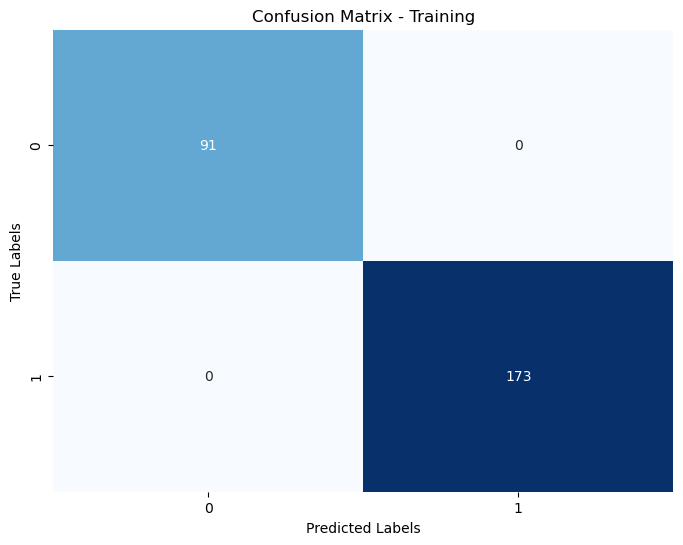

2024-08-08 17:49:28.302 | INFO     | __main__:evaluate_cf_model:18 - Validation - Accuracy: 0.7978, Precision: 0.8044, Recall: 0.7978, F1 Score: 0.8006


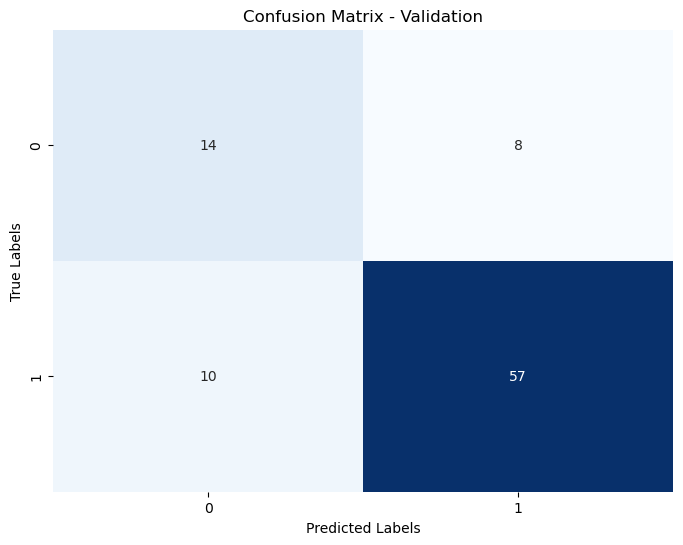

2024-08-08 17:49:28.729 | INFO     | __main__:evaluate_cf_model:18 - Test - Accuracy: 0.7528, Precision: 0.7505, Recall: 0.7528, F1 Score: 0.7513


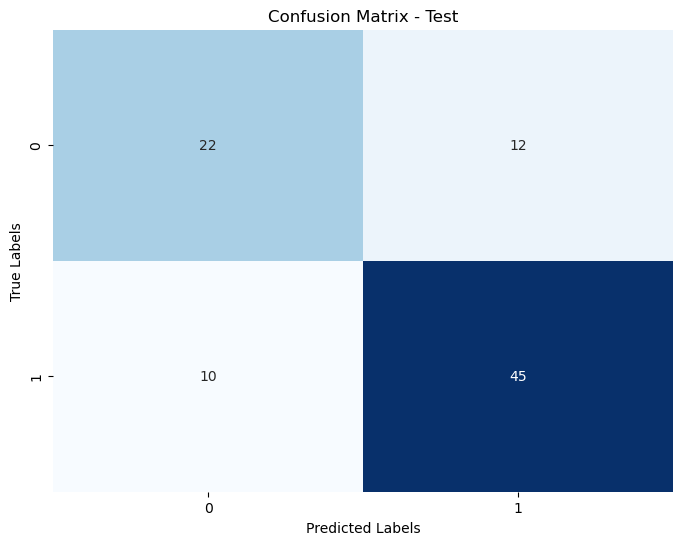

In [11]:
# Evaluate the model
evaluate_cf_model(model, X_train, y_train, "Training", display_matrix=True)
evaluate_cf_model(model, X_val, y_val, "Validation", display_matrix=True)
evaluate_cf_model(model, X_test, y_test, "Test", display_matrix=True)

In [12]:
# Get feature importance
feature_names = X_train.columns.tolist()
feature_importance = pd.DataFrame({
    'feature': feature_names,
    #'importance': model.named_steps['regressor'].feature_importances_
    'importance': model.named_steps['classifier'].feature_importances_
}).sort_values('importance', ascending=False)

logger.info("Top 5 important features:")
logger.info(feature_importance.head().to_string(index=False))

logger.success("Model training and evaluation complete.")

2024-08-08 17:49:29.503 | INFO     | __main__:<module>:9 - Top 5 important features:
2024-08-08 17:49:29.519 | INFO     | __main__:<module>:10 - feature  importance
     s5    0.194611
    bmi    0.164876
     s3    0.114334
     s6    0.108479
    age    0.089821
2024-08-08 17:49:29.525 | SUCCESS  | __main__:<module>:12 - Model training and evaluation complete.


In [13]:
from responsibleai import RAIInsights
from raiwidgets import ResponsibleAIDashboard
from responsibleai.feature_metadata import FeatureMetadata

In [14]:
def prepare_rai_data(model, X_test, y_test):
    """
    Prepare data for RAI Insights.
    
    Args:
    model: Trained model
    X_test: Test features
    y_test: Test target
    
    Returns:
    Tuple of (model, X_test, y_test) prepared for RAI Insights
    """
    print("Shape of X_test:", X_test.shape)
    print("Shape of y_test:", y_test.shape)
    
    # Ensure X_test is a DataFrame
    if not isinstance(X_test, pd.DataFrame):
        X_test = pd.DataFrame(X_test)
    
    # Ensure y_test is a Series (1d array)
    if isinstance(y_test, pd.DataFrame):
        y_test = y_test.iloc[:, 0]
    elif isinstance(y_test, np.ndarray) and y_test.ndim > 1:
        y_test = y_test.ravel()
    
    # Convert y_test to a Series if it's not already
    if not isinstance(y_test, pd.Series):
        y_test = pd.Series(y_test, name='target')
    
    print("Shape of y_test after conversion:", y_test.shape)
    
    # Reset index of X_test and y_test
    X_test = X_test.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    
    # Combine X_test and y_test into a single DataFrame
    test_df = pd.concat([X_test, y_test], axis=1)
    
    print("Shape of final test_df:", test_df.shape)
    print("Columns in test_df:", test_df.columns)
    print("First few rows of 'target' column:")
    print(test_df['target'].head())
    
    return model, test_df, 'target'

In [15]:
def create_rai_insights(model, X_test, y_test, task_type='classification'):
    """
    Create and compute comprehensive RAI Insights.
    
    Args:
    model: Trained model
    X_test: Test features
    y_test: Test target
    task_type: 'regression' or 'classification'
    
    Returns:
    RAIInsights object
    """
    # Prepare data for RAI Insights
    model, test_df, target_column = prepare_rai_data(model, X_test, y_test)
    
    print("Shape of test_df after prepare_rai_data:", test_df.shape)
    print("Columns in test_df:", test_df.columns)
    print("First few rows of 'target' column:")
    print(test_df[target_column].head())
    
    # Define feature metadata
    feature_metadata = FeatureMetadata()
    # Add your categorical features here, for example:
    #feature_metadata.add_categorical_feature('sex')
    
    # Create RAI Insights object
    rai_insights = RAIInsights(model, test_df, test_df, target_column,
                               task_type=task_type,
                               feature_metadata=feature_metadata)
    
    # Add explainer
    rai_insights.explainer.add()
    
    # Add error analysis
    rai_insights.error_analysis.add()
    
    # Add causal analysis
    # Note: This requires specific treatment features
    rai_insights.causal.add(treatment_features=['bmi', 'bp', 's5'])
    
    # Add counterfactuals
    if task_type == 'regression':
        # For regression, we need to specify a desired range
        y_min, y_max = test_df[target_column].min(), test_df[target_column].max()
        y_range = y_max - y_min
        desired_range = [y_min - 0.1 * y_range, y_max + 0.1 * y_range]  # Extend slightly beyond observed range
        rai_insights.counterfactual.add(total_CFs=10, desired_range=desired_range)
    else:
        # For classification, we need to specify the desired_class
        # Use 'opposite' for binary classification
        rai_insights.counterfactual.add(total_CFs=10, desired_class='opposite')
    
    # Add data balance measures only for classification tasks
    if task_type == 'classification':
        cols_of_interest = [col for col in test_df.columns if col != target_column]
        rai_insights.data_balance.add(cols_of_interest=cols_of_interest)
    
    # Compute insights
    rai_insights.compute()
    
    return rai_insights

In [16]:
# Create and compute RAI Insights
rai_insights = create_rai_insights(model, X_test, y_test, task_type='classification')
logger.info("RAI Insights computed")

# Display the RAI Dashboard
ResponsibleAIDashboard(rai_insights)
logger.success("RAI Dashboard launched. Model training and analysis complete.")

Shape of X_test: (89, 10)
Shape of y_test: (89,)
Shape of y_test after conversion: (89,)
Shape of final test_df: (89, 11)
Columns in test_df: Index(['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6',
       'target'],
      dtype='object')
First few rows of 'target' column:
0    1
1    0
2    1
3    1
4    1
Name: target, dtype: int64
Shape of test_df after prepare_rai_data: (89, 11)
Columns in test_df: Index(['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6',
       'target'],
      dtype='object')
First few rows of 'target' column:
0    1
1    0
2    1
3    1
4    1
Name: target, dtype: int64
Causal Effects
Current Status: Generating Causal Effects.


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

Current Status: Finished generating causal effects.
Time taken: 0.0 min 30.845588229 sec
Counterfactual
Current Status: Generating 10 counterfactuals for 89 samples


  3%|▎         | 3/89 [37:55<18:06:58, 758.35s/it]


KeyboardInterrupt: 